# IEOR 4418 Homework 2
## By Austin Slakey

### Problem 1
Recall the Transportation Problem we discussed in class.

**a) Suppose I increase the supply at some of the suppliers. How does this affect the optimal solution?**<br>
First, we assume that the original problem is formulated with enough supply to fill demand ($\sum{s_i} \geq \sum {d_j}$).  Then for the extended problem, we can assume two cases:<br>
        1) The new supply is placed with expensive suppliers. The optimal solution will put this excess supply on the dummy demand denoted by "z," and our objective function will not change (i.e. $f_{iz}$ will have some positive flow with cost = 0).<br>
        2) The new supply is placed with cheaper suppliers, so the optimal solution will reroute more flow to these cheaper routes.  Our objective function will decrease. 

    
**b) Suppose I increase the supply at some of the suppliers and the demand at some of the consumers. Does the total cost increase, decrease, or it depends. Argue your case and/or provide examples to prove your point.**<br>
It depends.  In general, you would assume an increase in costs because more flow is being sent across a network with positive costs.  However, one can easily imagine a situation in which more supply is placed at the very cheapest suppliers.  In such a case, rerouting flow to these cheaper edges could more than make up for the overall increase in flow thereby decreasing the objective function.

Here is a very simple example:
Suppliers A and B are fully connected to demand 1 and 2. There is originally more supply at A, but it is much cheaper to send from B.  So, our optimal objective can actually go down even if we increase the total flow being sent from 15 to 20 units.  On the other hand, if the cost from B to the consumers was the same as A, our objective function would increase.


In [21]:
from scipy.optimize import linprog
'''
min 20*FA1 + 20*FA2 + 1*FB1 + 1*FB2 + 0*FAZ + 0*FBZ
Demand:         Supply:
1 = 10          A = 10
2 = 5           B = 5
'''

c = [20,20,1,1,0,0] #Fa1,Fa2,Fb1,Fb2,Faz,Fbz
A = [[1, 1,0,0,1,0], [0, 0,1,1,0,1],[-1, 0,-1,0,0,0],[0, -1,0,-1,0,0]] #LHS of LS constraints (supply A, supply B, Demand 1, Demand 2)
b = [10, 5,-10,-5] #rhs of LS constraints (supply A, supply B, Demand 1, Demand 2)

first = linprog(c, A_ub=A, b_ub=b,
               options={"disp": True})
print("Original problem: "+ str(first.fun)) #objective = 205. Send 10 from A and 5 from B (obviously)

'''
Increase Supply and Demand
Demand:         Supply:
1 = 10          A = 10
2 = 10          B = 15
'''
#Now increase supply at B and demand at 1
b = [10, 15,-10,-10] #rhs of LS constraints (supply A, supply B, Demand 1, Demand 2)

second = linprog(c, A_ub=A, b_ub=b,
               options={"disp": True})
print("Increased Demand and Supply: "+ str(second.fun)) #objective = 115.  Now we can send 15 from B and only need 5 from A

Optimization terminated successfully.
         Current function value: 205.000000  
         Iterations: 4
Original problem: 205.0
Optimization terminated successfully.
         Current function value: 115.000000  
         Iterations: 5
Increased Demand and Supply: 115.0


### PROBLEM 2
We focus on applying the Route Inspection Problem on a real world example.<br><br>
**a) Find a neighborhood in New York City that is strongly connected. Let nodes cor- respond to intersections and edges correspond to roads. A two way street should correspond to two edges, one in each direction. Your neighborhood (directed graph) should have at least 8 nodes. Let edge costs of the graph correspond to approximate time to travel on the edge. This can be done with educated guessing. Draw the corresponding graph and label the streets.**<br>
I chose the streets between 1st and 2nd Avenue; Houston and 3rd street in the east village for part a) of Problem 2.  In this graph all Avenue edges have a weight of .5 and all street edges have a weight of 1 except for Houston which often has traffic.  So these 2 edges (Houston is two-ways) have a weight of 4.<br><br>

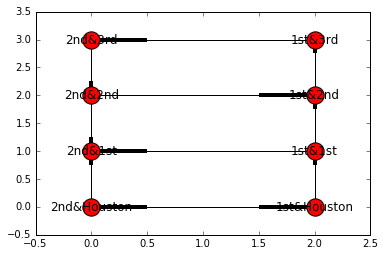

In [34]:
%matplotlib inline
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.DiGraph()

G.add_edges_from([('1st&Houston', '2nd&Houston'),('2nd&Houston','1st&Houston')], weight=3)
G.add_edges_from([('1st&1st','2nd&1st'),('2nd&2nd','1st&2nd'),('1st&3rd','2nd&3rd')], weight=1)
G.add_edges_from([('1st&Houston','1st&1st'),('2nd&Houston','2nd&1st'),('1st&1st','1st&2nd'),('1st&2nd','1st&3rd'),('2nd&3rd','2nd&2nd'),('2nd&2nd','2nd&1st')], weight=.5)
positions = {'1st&Houston':(2,0),'2nd&Houston':(0,0),'1st&1st':(2,1),'1st&2nd':(2,2),'1st&3rd':(2,3),'2nd&1st':(0,1),'2nd&2nd':(0,2),'2nd&3rd':(0,3)}

nx.draw_networkx(G,arrows=True,pos=positions) 

**b) Code the linear optimization formulation for the Route Inspection Problem (re- member to include it) and find the optimal flow. Hint: It may be easier to de- scribe your graph as a matrix like in previous homework. Then your optimization formulation should be couple lines of code if you use an optimization modeling language.**<br><br>


In [8]:
#Finding the optimal path is simple. Make the lower bound on all edges = 1, preserve flow balance in nodes
# To do this I translated this data to a matrix (just using excel) with costs of 100 on nonexistant edges

#****LEGEND: 0=1st and Houston 1=1st and 1st 2=1st and 2nd 3=1st and 3rd
#****        4=2nd and Houston 5=2nd and 1st 6=2nd and 2nd 7=2nd and 3rd 

from scipy.optimize import linprog
import pandas as pd
import numpy as np
import random

'''
Route Inspection as NFP:
min C_ij*F_ij
s.t.   X_i >= 1
       Flow in = Flow out for all nodes
'''

#read CSV file
df = pd.read_csv("EastVillage.csv",header=None)
graph = df.as_matrix()

#flatten into 1-d array of costs for simplex algo
c = graph.flatten()

#compute flow balance (sum Ax = b)
b = [0]*len(graph) #each node has flow_in - flow_out = 0
#This outputs a constraint for each intersection:
# Outgoing edge = 1
# Incoming edge = -1
A= list() 
for i in range(len(graph)):
    Intersection = [0]*(len(graph)**2)
    for j in range(len(graph)):
        if i == j: #no self serving nodes
            continue
        if graph[i][j]<100: #then this is an outbound edge
            Intersection[i*len(graph)+j] = 1
        if graph[j][i]<100: #then this is an inbound edge
            Intersection[j*len(graph)+i] = -1
    A.append(Intersection)
#Bounds on edges:
Bounds = list()
for i in range(len(c)):
    if c[i]!=100: #real edges must be covered
        Bounds.append( (1,None) )
    else: #fake edges do not need to be covered
        Bounds.append( (0,None) )
        
flow = linprog(c, A_eq=A, b_eq=b,bounds=Bounds,
               options={"disp": True})
print("Optimal Objective: "+ str(flow.fun))
optimal_flow = flow.x.reshape(len(graph),len(graph))
print(optimal_flow)

Optimization terminated successfully.
         Current function value: 21.000000   
         Iterations: 18
Optimal Objective: 21.0
[[ 0.  2.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.]
 [ 3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2.  0.]]


**c) Convert your flow to an optimal route, and show your work.**<br>

In [12]:
'''
Create Route from Optimal Flow

This algorithm is a little tricky to set up, 
but after that it is fairly straight forward

We need input of an optimal flow matrix
1) Go through matrix finding cycles W1,W2,...,Wn

Data Structs:

ordered dictionary - For each cycle create an ordered dictionary (a list has the next key)
that will count how many times we have visited
unvisited set - set of unvisited cycles
S - stack of visited cycles
i - the path

2) Algorithm
initialize S = W1, W = W1 i = random node from W
while S not empty:
    Let i next node in W (and append it to path)
    if i has been visited on current cycle:
        S = S\W
        W = last cycle added to S
    if i is in new cycle W':
        add W' to S
        W = W'
'''
#STEP 1) Save Cycles
#create cycle dictionary {key:[node_to,times visited]}
def find_cycle(path,last,edges,Cycles):
    cycle = dict()
    while True:
        next_node = path[last]
        cycle[last] = [next_node,0]
        edges[last][next_node] = edges[last][next_node]-1
        if next_node in cycle.keys(): #we finished a cycle
            break
        last = next_node
        
    Cycles.append(cycle)
    return (Cycles,edges)

Cycles = list()
#search for cycle
g_copy = np.copy(optimal_flow)
#print("Optimal Flow Matrix")
#print(g_copy)
starting_nodes= set(range(len(graph)))
while len(starting_nodes)!=0:
    
    start = random.choice(tuple(starting_nodes))
    path = dict()
    i = start
    j = 0
    while j < len(g_copy):
        if g_copy[i][j] > 0: #Go to j
            path[i] = j
            if j in path.keys(): #we just found a cycle
                Cycles,g_copy = find_cycle(path,j,g_copy,Cycles) #add cycle to Cycles list, and delete those edges
                break
            i = j
            j = 0
            continue
        j+=1
    starting_nodes= set(np.where(np.sum(g_copy, axis=1)>0)[0])
#print("all Edges Used")
#print(g_copy) 
print("Cycles: ")
print(Cycles)

Cycles: 
[{2: [3, 0], 3: [7, 0], 6: [2, 0], 7: [6, 0]}, {0: [1, 0], 1: [2, 0], 2: [3, 0], 3: [7, 0], 4: [0, 0], 5: [4, 0], 6: [5, 0], 7: [6, 0]}, {0: [1, 0], 1: [5, 0], 4: [0, 0], 5: [4, 0]}, {0: [4, 0], 4: [0, 0]}]


In [13]:
#STEP 2) The Algorithm

S = list()
path = list()
Unvisited = set()

#initialze variables
for i in range(len(Cycles)):
    Unvisited.add(i)
S.append(Cycles[0])
Unvisited.remove(0)
i = random.choice(tuple(S[-1].keys()))
path.append(i)

while len(S)>0:
    W = -1
    S[W][i][1] = S[W][i][1] + 1
    i = S[-1][i][0]
    path.append(i)
    #print(path)
    if S[W][i][1] > 0: #we have visited on this cycle
        S.pop()
        #print("one cycle down")
    for j in Unvisited:
        if i in Cycles[j].keys(): #i is in a new cycle. Lets start traversing that
            S.append(Cycles[j])
            Unvisited.remove(j)
            #print("on new cycle")
            break
print(path) #that works!

[3, 7, 6, 5, 4, 0, 4, 0, 1, 5, 4, 0, 1, 2, 3, 7, 6, 2, 3]


### PROBLEM 3
3. Consider the following variations of the Route Inspection problem.<br><br>
**a) Suppose we have two trucks instead of one. What should be our objective?**<br>
**b) Provide a seemingly reasonable heuristic to part a) that uses our algorithm for one truck.**<br>
**c) Implement your idea from part b) on the graph you constructed in Question 2.**<br>